# Solar Irradiance Prediction

## Author: Spriha Ghosh

![ChessUrl](https://media3.giphy.com/media/3oEjHKGZDGJ9KQRd96/giphy.gif?cid=790b761196cd80790c6421fc717c7ba0a62b750bb16f8dfa&rid=giphy.gif&ct=g "chess")

In [1]:
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import statsmodels.formula.api as smf
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pandas

In [2]:
data=pd.read_csv('../input/SolarEnergy/SolarPrediction.csv')

## Visualizing Exisitng Correlations

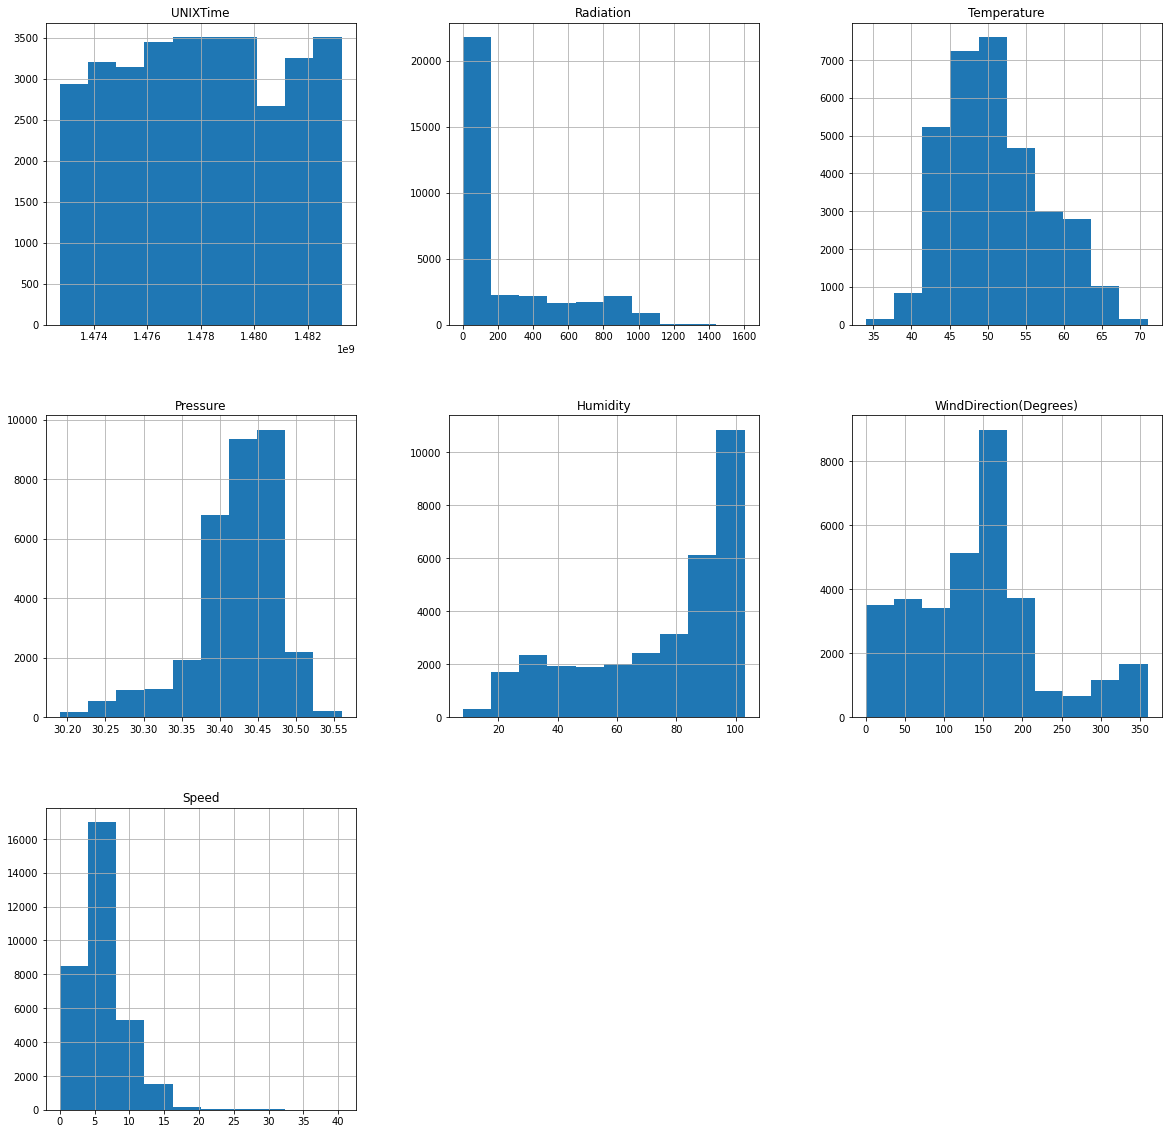

In [3]:
data.hist(figsize=(20,20))
plt.show()

<AxesSubplot:>

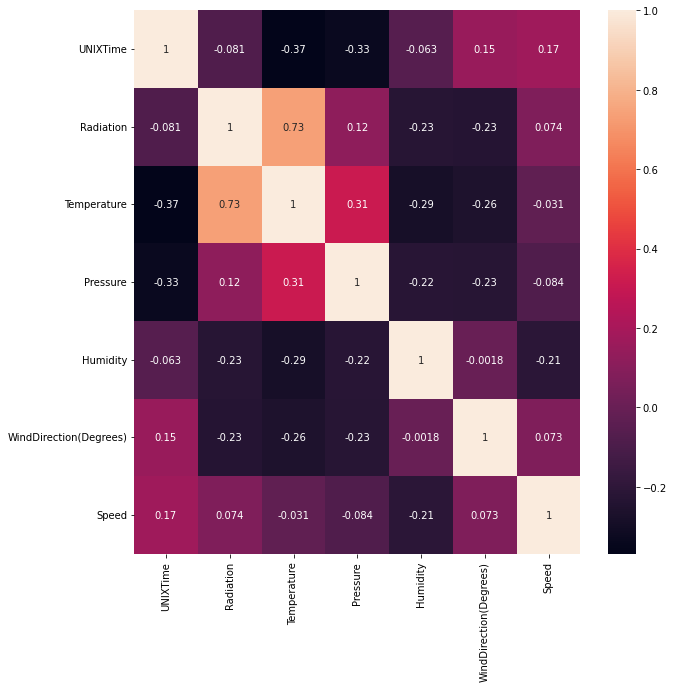

In [4]:
figure= plt.figure(figsize=(10,10))
sns.heatmap(data.corr(),annot=True)

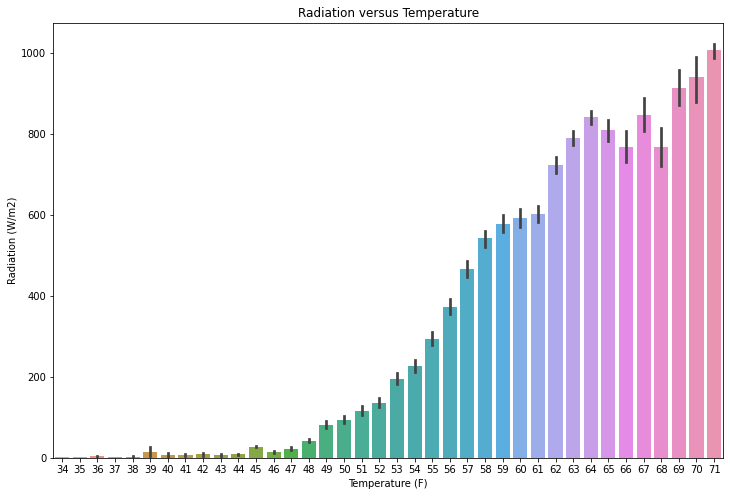

In [5]:
plt.figure(figsize=(12,8))
sns.barplot(x=data['Temperature'],y=data['Radiation'])
plt.xlabel('Temperature (F)')
plt.ylabel('Radiation (W/m2)')
plt.title('Radiation versus Temperature')
plt.show()

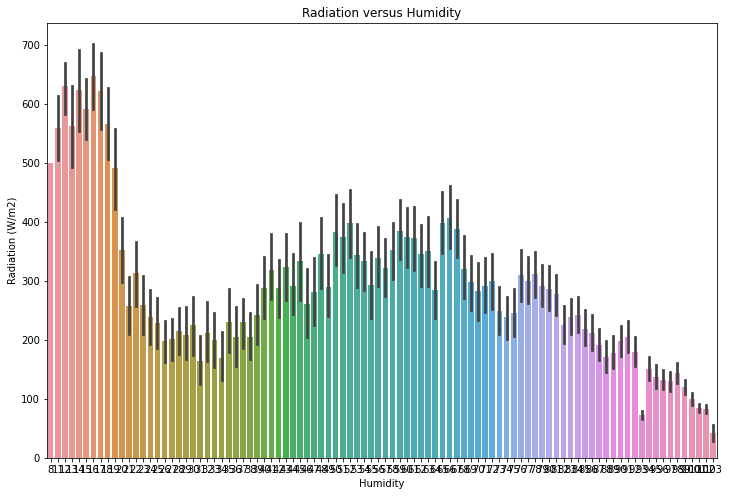

In [6]:
plt.figure(figsize=(12,8))
sns.barplot(x=data['Humidity'],y=data['Radiation'])
plt.xlabel('Humidity')
plt.ylabel('Radiation (W/m2)')
plt.title('Radiation versus Humidity')
plt.show()

In [7]:
from scipy import stats
def corrfunc(x, y, **kws):
    '''add pearsonr correlatioin to plots'''
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),xy=(.1, .9), xycoords=ax.transAxes, color='white')
    return

def corrMap(data,features):
    '''plot bivariate correlations'''
    g = sns.PairGrid(data, vars=features)
    g.map_upper(plt.scatter, s=10)
    g.map_diag(sns.distplot, kde=False)
    g.map_lower(sns.kdeplot, cmap="coolwarm", shade=True, n_levels=30)
    g.map_lower(corrfunc)
    g.map_lower(corrfunc)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


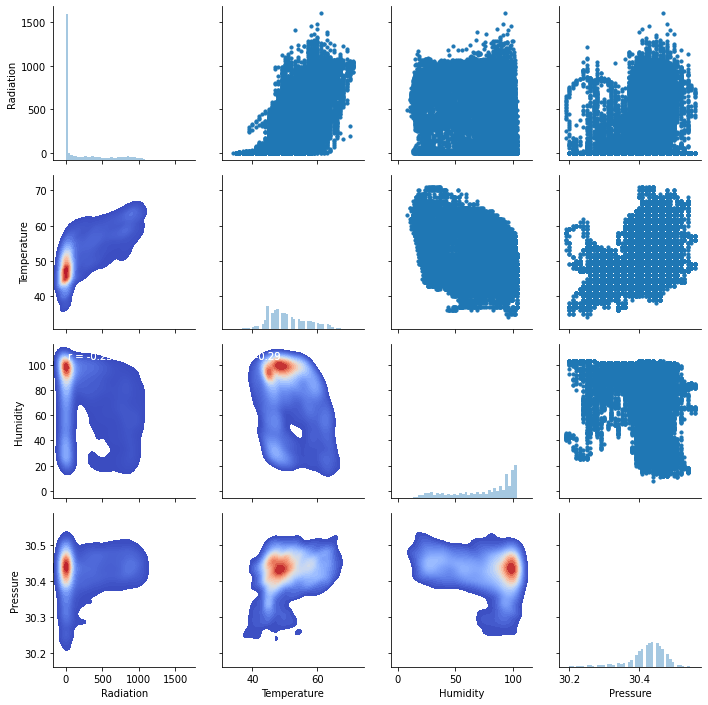

In [8]:
feature_list=['Radiation','Temperature','Humidity','Pressure']
# bivariate density matrix
corrMap(data,feature_list)
plt.show()

## Feature Engineering

![alt](https://solcast.com/uploads/asia_ens1235_2018-09-13_0423.gif)
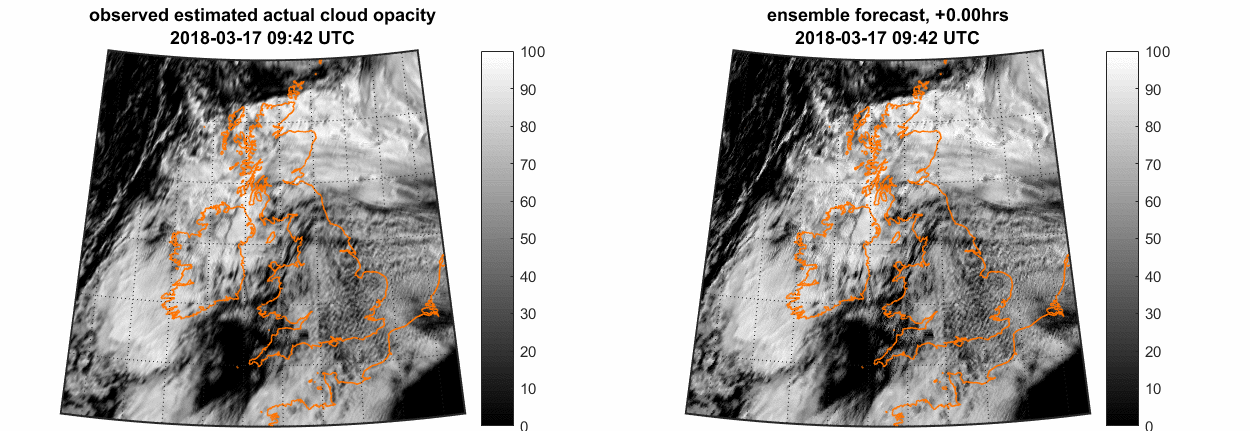

In [9]:
#Covert time to_datetime
#Add column 'hour'
data['Time_conv'] =  pd.to_datetime(data['Time'], format='%H:%M:%S')
data['hour'] = pd.to_datetime(data['Time_conv'], format='%H:%M:%S').dt.hour

#Add column 'month'
data['month'] = pd.to_datetime(data['UNIXTime'].astype(int), unit='s').dt.month

#Add column 'year'
data['year'] = pd.to_datetime(data['UNIXTime'].astype(int), unit='s').dt.year

#Duration of Day
data['total_time'] = pd.to_datetime(data['TimeSunSet'], format='%H:%M:%S').dt.hour - pd.to_datetime(data['TimeSunRise'], format='%H:%M:%S').dt.hour
data.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Time_conv,hour,month,year,total_time
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,1900-01-01 23:55:26,23,9,2016,12
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,1900-01-01 23:50:23,23,9,2016,12
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,1900-01-01 23:45:26,23,9,2016,12
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,1900-01-01 23:40:21,23,9,2016,12
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,1900-01-01 23:35:24,23,9,2016,12


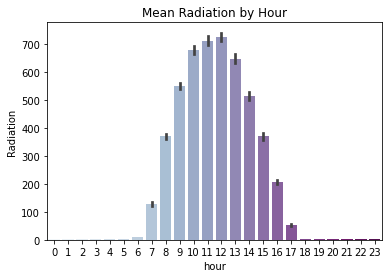

In [10]:
ax = plt.axes()
sns.barplot(x="hour", y='Radiation', data=data, palette="BuPu", ax = ax)
ax.set_title('Mean Radiation by Hour')
plt.show()

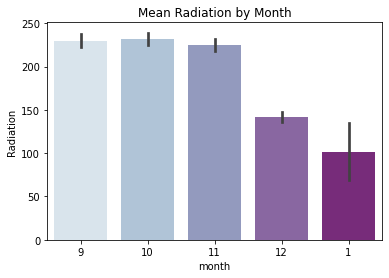

In [11]:
ax = plt.axes()
sns.barplot(x="month", y='Radiation', data=data, palette="BuPu", ax = ax, order=[9,10,11,12,1])
ax.set_title('Mean Radiation by Month')
plt.show()

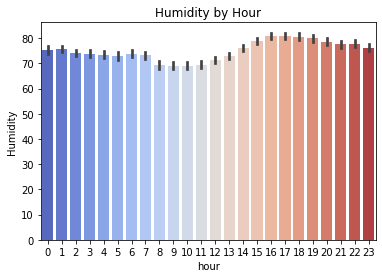

In [12]:
ax = plt.axes()
sns.barplot(x="hour", y='Humidity', data=data, palette=("coolwarm"), ax = ax)
ax.set_title('Humidity by Hour')
plt.show()

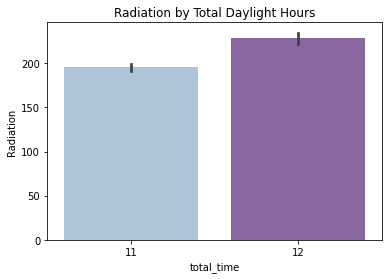

In [13]:
ax = plt.axes()
sns.barplot(x="total_time", y='Radiation', data=data, palette="BuPu", ax = ax)
ax.set_title('Radiation by Total Daylight Hours')
plt.show()

In [14]:
X=data[['Temperature', 'Pressure', 'Humidity', 'Speed',
       'total_time', 'hour', 'year', 'month',
       'WindDirection(Degrees)']]
Y=data.Radiation
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
X_train, X_test, Y_train, Y_test= train_test_split(X, Y, random_state= 0)
def model_score_error(model):
    prepared_model=model.fit(X_train, Y_train)
    x=prepared_model.score(X_test,Y_test)
    print('Score: ',x)
    Target_predicted=prepared_model.predict(X_test) 
    MSE=mean_squared_error(Y_test,Target_predicted) 
    print('mean square error', MSE)

![alt](https://solcast.com/uploads/solar-data-api-global-coverage-fast-free.gif)
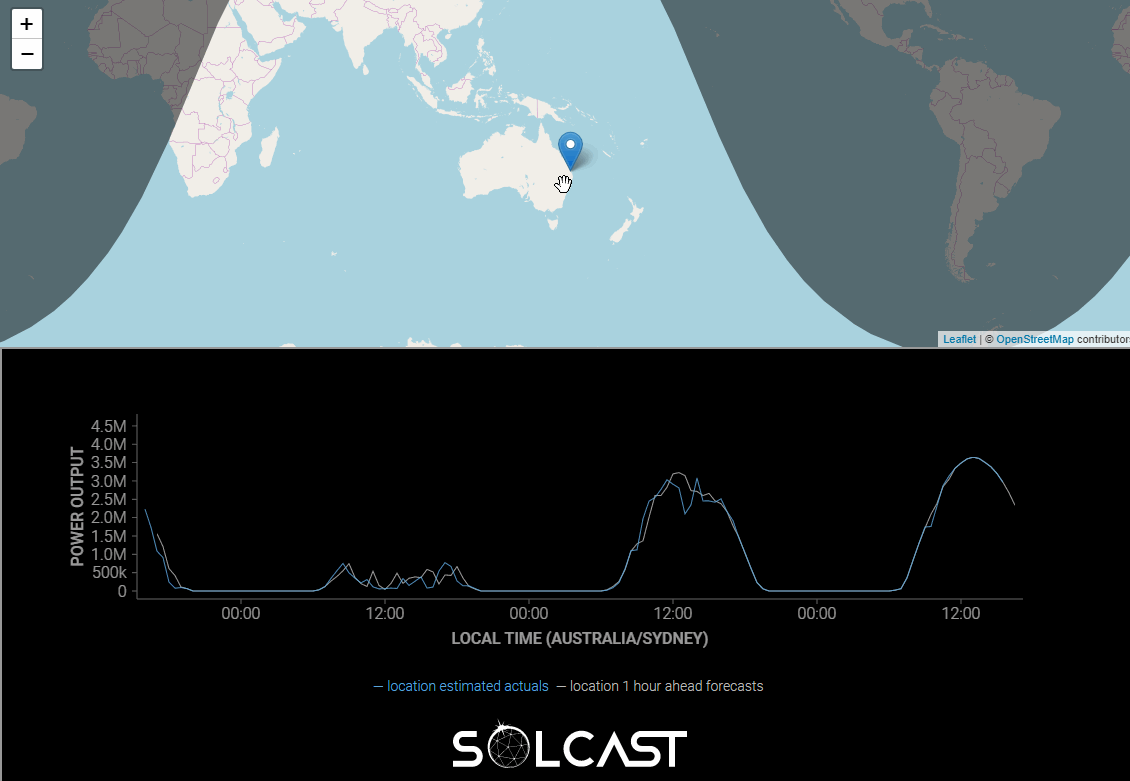

## Lasso Regression

In [15]:
# lasso is very sensitive to outliers. so make it more robust
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=50))
model_score_error(lasso)

Score:  0.6187617334691362
mean square error 37783.65065673978


## ElasticNet

In [16]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
model_score_error(ENet)

Score:  0.618786187335659
mean square error 37781.22709008602


## Decision Tree Regression

In [17]:
from sklearn.tree import DecisionTreeRegressor
DTregressor = DecisionTreeRegressor(random_state=0).fit(X_train, Y_train)
model_score_error(DTregressor)

Score:  0.8456475080407955
mean square error 15297.52164506729


## Gradient Boost Regression

In [18]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =5)
model_score_error(GBoost)

Score:  0.8953479776033613
mean square error 10371.822038582768
